# SHAP值

## SHAP值的基本原理
**SHAP(SHapley Additive exPlanations)**是一种基于博弈论的解释机器学习模型输出的方法。它的核心思想来源于博弈论中的Shapley值概念，用于公平地分配合作博弈中各个玩家的贡献。

在机器学习模型中：
- 每个特征被视为一个"玩家"
- 模型的预测结果被视为"游戏收益"
- SHAP值就是计算每个特征对预测结果的"边际贡献"

## SHAP值的主要特点：
   - **一致性**：如果模型改变使得某个特征更重要，其SHAP值会相应增加
   - **准确性**：所有特征的SHAP值之和等于模型预测与平均预测的差值
   - **可加性**：多个特征的SHAP值可以相加来理解它们的组合效应

## SHAP值的优缺点

- **优点**

| 优点                   | 说明                           |
| -------------------- | ---------------------------- |
| **理论保证**             | 基于博弈论，具有公平性、一致性等数学性质         |
| **通用性**              | 可用于任意机器学习模型（如 tree、NN、SVM）   |
| **局部解释**             | 可以解释每一个单独预测值                 |
| **全局解释**             | 聚合 SHAP 值可提供特征重要性排名          |
| **一致性（Consistency）** | 如果模型改进后某特征的影响变大，其 SHAP 值也会一致变大 |

- **缺点**

| 缺点           | 说明                           |
| ------------ | ---------------------------- |
| **计算复杂**     | 计算成本指数级，消耗资源较大        |
| **特征依赖性问题**  | 默认特征相互独立，可能不适用于强相关特征         |
| **可解释性误用风险** | 对模型机制不了解可能误解 SHAP 的意义        |


## SHAP值的适用场景

| 场景       | 示例                        |
| -------- | ------------------------- |
| **模型调试** | 了解模型是否学习了错误特征             |
| **特征选择** | 根据全局 SHAP 值筛选重要特征         |
| **监管解释** | 银行/医疗等对可解释性有要求的行业         |
| **客户报告** | 向非技术人员解释模型为什么做出某个预测       |
| **异常检测** | 对 SHAP 值分布分析，发现异常样本或过拟合特征 |


# 案例数据

## 波士顿房价数据集

**Boston Housing Dataset（波士顿房价数据集）**是一个回归数据集，该数据集包含506个样本，每个样本有13个特征，该数据集用于根据犯罪率、房屋房间数、空气污染等因素对波士顿地区的房价进行预测。

- MEDV：住房价格中位数（单位：千美元）
- CRIM：该镇的人均犯罪率
- ZN：住宅用地超过 25000 平方英尺的比例（%）
- INDUS：非零售商用土地比例（%）
- CHAS：是否靠近查尔斯河（1=是，0=否）
- NOX：一氧化氮浓度（空气污染指标，单位：ppm）
- RM：每栋住宅的平均房间数
- AGE：1940 年之前建成房屋的比例（%）
- DIS：到波士顿五个中心区域的加权距离
- RAD：距离高速公路的便利指数
- TAX：每 $10,000 资产的房产税率
- PTRATIO：城镇师生比例
- B：黑人比例指标
- LSTAT：低收入人群比例（%）

In [8]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 加载波士顿房价数据集
# 该数据集包含506个样本，每个样本有13个特征，用于预测房价
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data  # 特征变量
y = boston.target  # 目标变量（房价）
boston

{'data':         CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  \
 0    0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0   
 1    0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0   
 2    0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0   
 3    0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0   
 4    0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0   
 ..       ...   ...    ...  ...    ...    ...   ...     ...  ..    ...   
 501  0.06263   0.0  11.93    0  0.573  6.593  69.1  2.4786   1  273.0   
 502  0.04527   0.0  11.93    0  0.573  6.120  76.7  2.2875   1  273.0   
 503  0.06076   0.0  11.93    0  0.573  6.976  91.0  2.1675   1  273.0   
 504  0.10959   0.0  11.93    0  0.573  6.794  89.3  2.3889   1  273.0   
 505  0.04741   0.0  11.93    0  0.573  6.030  80.8  2.5050   1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   9.14  
 2       

## 训练代码

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 2.39156	train's l1: 1.76579	train's l2: 5.71956	valid's rmse: 3.49944	valid's l1: 2.50288	valid's l2: 12.2461
[100]	train's rmse: 0.73383	train's l1: 0.543794	train's l2: 0.538506	valid's rmse: 2.55321	valid's l1: 1.92145	valid's l2: 6.51886
[150]	train's rmse: 0.297076	train's l1: 0.221616	train's l2: 0.0882539	valid's rmse: 2.41457	valid's l1: 1.83619	valid's l2: 5.83014
[200]	train's rmse: 0.146277	train's l1: 0.108369	train's l2: 0.021397	valid's rmse: 2.38429	valid's l1: 1.82178	valid's l2: 5.68483
[250]	train's rmse: 0.0826233	train's l1: 0.0600324	train's l2: 0.00682661	valid's rmse: 2.37487	valid's l1: 1.81397	valid's l2: 5.64003
[300]	train's rmse: 0.0533655	train's l1: 0.038059	train's l2: 0.00284788	valid's rmse: 2.37255	valid's l1: 1.81231	valid's l2: 5.62899
[350]	train's rmse: 0.0367844	train's l1: 0.0265852	train's l2: 0.00135309	valid's rmse: 2.37138	valid's l1: 1.81161	valid's l2: 5.62342
E

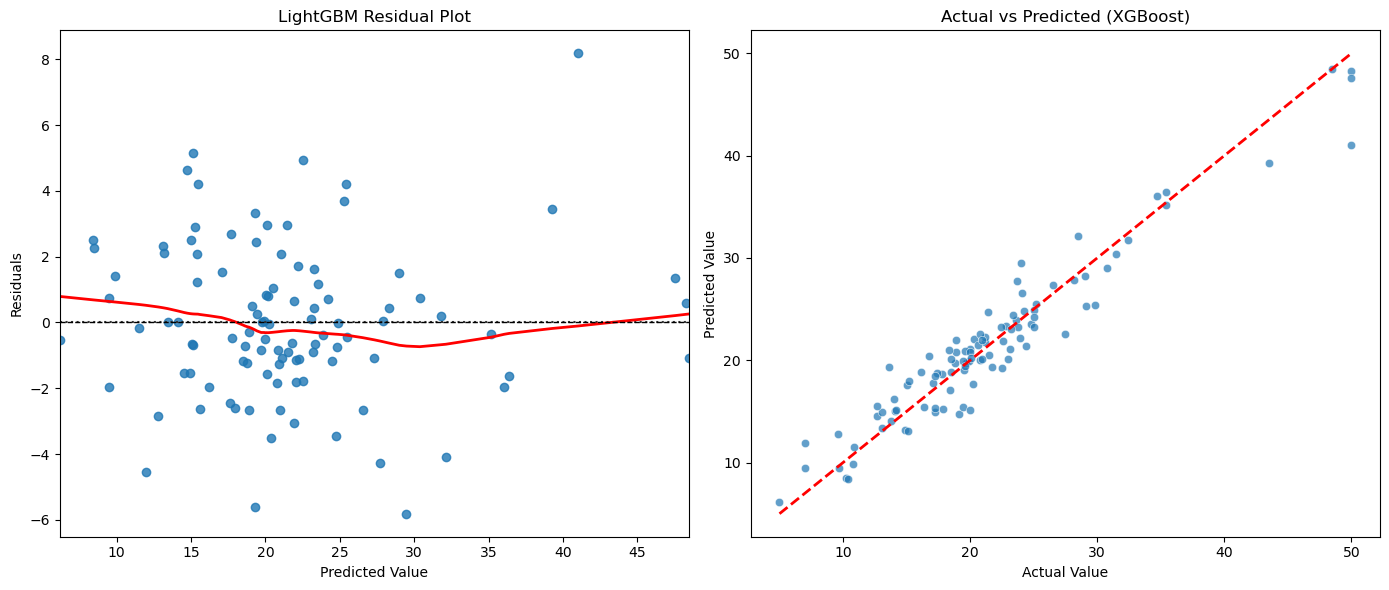

In [9]:
# 分割数据集为训练集和验证集（80% / 20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============ 4. 构建LightGBM数据集 ============
dtrain = lgb.Dataset(X_train, label=y_train)  # 训练集
dtest = lgb.Dataset(                          # 验证集
    X_test, 
    label=y_test
)

# ============ 5. 配置模型参数 ============
params = {
    # 任务类型和评估指标
    'objective': 'regression',   # 回归任务
    'metric': {'rmse','l1','l2'},   # 回归损失
    
    # 树结构控制
    'num_leaves': 60,       # 叶子节点数（控制模型复杂度）
    'max_depth': -1,        # -1表示不限制深度（通常用num_leaves控制）
    'min_data_in_leaf': 2, # 叶子节点最小样本数（防过拟合）
    
    # 训练过程控制
    'learning_rate': 0.03,  # 学习率（步长）
    'feature_fraction': 0.9, # 每轮随机选择90%特征
    'bagging_fraction': 0.8, # 每轮随机选择80%数据
    
    # 正则化
    'lambda_l1': 0.1,       # L1正则化系数
    'lambda_l2': 0.01,     # L2正则化系数
    
    # 其他
    'verbosity': -1,        # 静默模式（不输出训练日志）
    'seed': 2019    # 随机种子
}


# 训练模型
lgb_reg = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,    # 最大迭代轮数
    valid_sets=[dtrain, dtest],  # 监控训练集和验证集表现
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 早停（50轮无提升停止）
        lgb.log_evaluation(period=50)            # 每50轮打印一次日志
    ]
)

# 使用训练好的模型对验证集进行预测
y_pred = lgb_reg.predict(X_test)

# 计算多种评估指标
mse = mean_squared_error(y_test, y_pred)               # 均方误差
rmse = np.sqrt(mse)                                    # 均方根误差
mae = mean_absolute_error(y_test, y_pred)              # 平均绝对误差
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # 平均绝对百分比误差
r2 = r2_score(y_test, y_pred)                          # 决定系数 R²（越接近1越好）

# 输出评估指标
print("=== 评估指标 (LightGBM 原生 API) ===")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# 计算残差（实际值 - 预测值）
residuals = y_test - y_pred

# 创建可视化图像（2 个子图）
plt.figure(figsize=(14, 6))

# 子图1：残差图（理想情况下残差应围绕0对称分布）
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred, y=residuals, lowess=True,
              line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("LightGBM Residual Plot")

# 子图2：实际值 vs 预测值（越接近对角线越好）
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted (XGBoost)")

# 自动调整图像排版
plt.tight_layout()
plt.show()

# shap可视化——依赖关系分析可视化

## 初始化解释器&计算shap值

In [10]:
import shap
shap.initjs()

# 初始化解释器
explainer = shap.Explainer(lgb_reg)

# 计算 SHAP 值（针对测试集）
shap_values = explainer(X_test)

## scatter交互效应散点图

### 基本概念

- **功能**：绘制交互效应散点图。展现了：
    - 每个样本的某个特征值（横轴）；
    - 该特征对预测的贡献（纵轴 SHAP 值）；
    - 颜色可用来表示另一个特征的数值，观察特征间交互。

### 交互效应散点图的组成要素

| 图形元素          | 含义                                    |
| ------------- | ------------------------------------- |
| **横轴（x）**     | 某个特征的原始取值                      |
| **纵轴（y）**     | 该特征的 SHAP 值，表示其对模型输出的影响（正→提高预测值，负→降低） |
| **点的颜色**      | 可选，通常代表另一个特征的值，用以揭示交互作用        |
| **点的分布形状**    | 显示模型对不同特征值的敏感程度或非线性关系                 |
| **灰色直方图**     | 可选，表示特征值的分布密度                         |
| **图例颜色条（右侧）** | 显示 color 指定特征的数值映射|

### `shap.plots.scatter()`
- `shap_values`: 必需参数，包含SHAP值的对象，通常来自shap.Explainer的计算结果
- `color`: 控制点的颜色
- `hist`: 是否在底部显示该特征的分布直方图。默认 True。
- `axis_color`: 坐标轴颜色，默认深灰
- `cmap`: 控制点颜色映射的颜色渐变方案
- `dot_size`: 散点大小，默认 16
- `alpha`: 控制散点透明度。取值范围0-1，1为不透明，0为完全透明
- `title`: 自定义图标题
- `xmin/xmax/ymin/ymax`: 控制坐标轴的范围
- `ylabel`: 设置纵轴名称。默认是 "SHAP value"

### 代码实现与结果解释

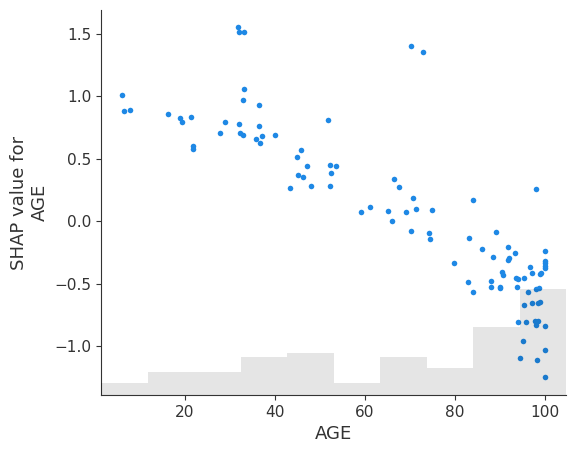

In [11]:
shap.plots.scatter(shap_values[:, "AGE"])

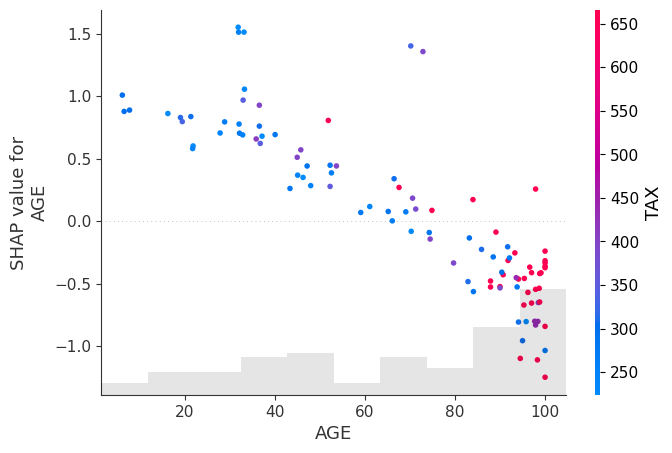

In [12]:
shap.plots.scatter(shap_values[:, "AGE"], color=shap_values[:, "TAX"])

**图表整体结构**
- **横轴**：特征 AGE 的实际取值（表示建于1940年以前的房屋百分比），范围大致在 0 到 100 之间
- **纵轴**：对应的 SHAP 值（AGE 对房价预测的贡献），范围约为 -1.2 到 +1.6
- **点的颜色**：表示另一个特征 TAX（房产税率）的值，使用颜色渐变：
    - **蓝色**：TAX 值较低（< 300）
    - **红色**：TAX 值较高（> 600）
    - **紫色过渡**：TAX 中间水平（~450）
- **灰色柱状图**：AGE 特征的样本分布（直方图），表示在各AGE区间的样本密度



**变量关系与趋势分析**
- **AGE 与房价贡献（SHAP值）的关系**
| AGE 范围      | SHAP值趋势    | 解释               |
| ----------- | ---------- | ---------------- |
| AGE < 60    | SHAP 值为正   | 表明房屋较新 → 提高房价预测值 |
| AGE > 70    | SHAP 值为负   | 表明房屋偏旧 → 降低房价预测值 |
| AGE ≈ 60–70 | SHAP 值接近 0 | AGE 对房价影响较小      |

    - **结论**：房屋越新，对房价预测的正向影响越强；房龄越大，对预测值拉低作用越大。
- **颜色变量（TAX）影响解读**
    - 高房产税（红色） 样本在高 AGE 区域更常见，且对应 SHAP 值多数为负：
        - 表明：老房子 + 高房产税 → 更强的价格压低效应
    - 低房产税（蓝色） 样本在低 AGE 区域常见，SHAP 值多数为正：
        - 表明：新房子 + 税低 → 共同促进房价上涨
        
**业务解读**

| 特征      | 变量意义               | 趋势总结                     |
| ------- | ------------------ | ------------------------ |
| AGE     | 房屋建成时间占比（老房子比例）    | 老房比例越高，房价越被拉低            |
| SHAP值   | `AGE` 对房价预测的单独贡献   | 从正到负变化，影响显著              |
| 颜色（TAX） | 房产税：每 \$10,000 的税收 | 高税 + 老房影响更负；低税 + 新房效果更正向 |

 shap.plots.scatter() 图直观展示了单一变量（AGE）对目标变量（MEDV）的贡献，并通过色彩进一步揭示了 AGE 与 TAX 的交互效应。适用于变量间的敏感性分析和模型可解释性沟通场景。

## heatmap热力图

### 基本概念

- **功能**：展示多个样本中各特征对模型预测的影响情况。热力图的核心价值在于：
    - **揭示特征影响的样本级模式**：显示不同样本中特征影响的动态变化
    - **识别全局特征重要性**：通过垂直方向的颜色密度反映特征的整体重要性
    - **发现异常行为**：检测特征影响与常规模式不符的特殊样本
- **特点**：
    - 行代表样本，列代表特征
    - 颜色深浅表示SHAP值大小
    - 适合中等规模数据集的全貌分析

### 热力图的组成要素

- **坐标系统**
    - **横轴(X轴)**：样本实例索引(通常0-100表示百分比或实际样本编号)
    - **纵轴(Y轴)**：特征名称，按重要性从上到下排序
    - **颜色轴**：SHAP值大小，用颜色深浅表示影响强度
- **视觉编码**
    - **颜色映射**：
        - 红色：SHAP 值为正 → 推高预测房价
        - 蓝色：SHAP 值为负 → 拉低预测房价
        - 颜色饱和度：表示SHAP值绝对值大小。越深，影响越大
    - **右侧刻度条**：标注SHAP值的具体数值范围
- **附加元素**
    - **预测值曲线**：顶部通常显示f(x)随样本的变化曲线
    - **特征汇总行**：底部可能显示"其他特征"的合计影响

### `shap.plots.heatmap()`
- `shap_values`: 必需参数，包含SHAP值的对象，通常来自shap.Explainer的计算结果
- `instance_order`: 控制样本（行）的排序，可设置为 None、range(n)、自定义列表
- `feature_values`: 控制特征（列）的排序方式，默认按 shap.Explanation.abs.mean(0)。可按均值、方差、自定义等
- `feature_order`: 显式指定特征排列顺序。默认值None
- `max_display`: 控制最多显示的特征数。默认值10
- `cmap`: 控制热力图色彩样式
- `plot_width`: 控制图表宽度

### 代码实现与结果解释

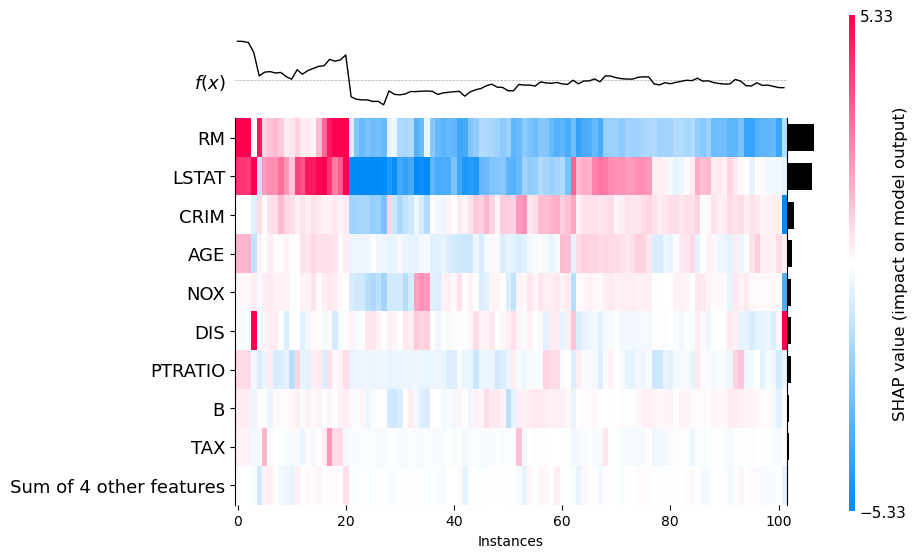

<Axes: xlabel='Instances'>

In [13]:
shap.plots.heatmap(shap_values)

**图表整体结构**
- **上部曲线**：显示模型预测值f(x)在样本间的波动情况
- **中部热力图**：特征SHAP值分布矩阵
    - X轴：样本索引(0-100%对应506个样本)
    - Y轴：按重要性排序的特征(RM → LSTAT → ... → 其他4特征)
    - 颜色编码：红色(正向影响)、蓝色(负向影响)，饱和度表示强度
- **右侧颜色条**：标注SHAP值范围(-5.33到+5.33)

**特征贡献分析**

| 排名 | 特征名                         | SHAP颜色分布（结合f(x)判断解读）         | 实际贡献分析                                  |
| -- | --------------------------- | ---------------- | --------------------------------------- |
| 1  | **RM**<br>（房间数）             | 左侧大多 🔴，右侧清一色 🔵 | **对房价影响最大**：房间数高 → 房价高（红），房间数低 → 房价低（蓝） |
| 2  | **LSTAT**<br>（低收入比例）        | 左侧多为 🔴，中间为 🔵   | **次强影响**：低收入人群比例高 → 房价低（蓝）；比例低 → 房价高（红） |
| 3  | **CRIM**<br>（犯罪率）           | 多为浅红，但零星出现蓝色     | 犯罪率越高 → 房价略低（蓝）；但影响较为分散                 |
| 4  | **AGE**                     | 大多颜色较淡，微弱红蓝      | 年代对房价影响有限；可能在某些样本中起辅助作用                 |
| 5  | **NOX**<br>（空气污染）           | 多为浅红             | 污染越高 → 房价略低（负向）但不强烈                     |
| 6  | **DIS**<br>（距离市中心）          | 有部分红色（正向）也有蓝色    | 离市中心越近，房价越高；但影响很小                    |
| 7  | **PTRATIO**<br>（师生比）        | 淡蓝为主，偶有红点        | 师生比高 → 房价高，但影响很小                        |
| 8  | **B**<br>（黑人比例指数）           | 大多颜色极浅           | 几乎无显著影响（现代数据中此变量应谨慎使用）                  |
| 9  | **TAX**<br>（税率）             | 大多为浅蓝，偶尔有红色            | 税率影响较小                       |
| 10 | **Sum of 4 other features** | 极浅红蓝交错           | 表示其余次要特征加起来的贡献，也很小                      |


**业务解读**
- **主导性影响因素**
    - **RM(平均房间数)**
        - 热力模式：深红色或者深蓝色
        - 业务发现：房间数对房屋价格影响大。房间数高 → 房价高（红），房间数低 → 房价低（蓝
    - **LSTAT(低收入人群比例)**
        - 热力模式：深红色或者深蓝色
        - 业务发现：低收入人群比例高 → 房价低（蓝）；比例低 → 房价高（红）
    - 应当围绕这些主导性影响因素做进一步探查、数据特征工程